In [209]:
 ## 1 https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 (Testa esse aqui tbm)
##Auctor: Shashank Kapadia

## 2 https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html 

##3 https://sigmoidal.ai/como-criar-uma-wordcloud-em-python/  -- WorldClouds ## 
##4 http://tirandolicoesdetudo.com.br/criando-uma-nuvem-de-palavras-wordcloud-com-dados-do-meu-cv/ -- WorldCloud ##

##5 https://www.youtube.com/watch?v=iQ1bfDMCv_c&list=PLf6b7z7NwdGVMXPEvoJu64jxtE58q4CH8&index=3&t=9s - Videos da ALICE ZHAO##
#https://github.com/adashofdata/nlp-in-python-tutorial


## 6 https://gist.github.com/alopes/5358189 - lista de StopWords em português com correspondências. 


## 7 https://medium.com/@viniljf/utilizando-processamento-de-linguagem-natural-para-criar-um-sumariza%C3%A7%C3%A3o-autom%C3%A1tica-de-textos-775cb428c84e

In [23]:
# Importing modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [56]:
import nltk 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Klemer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Klemer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [65]:
#Importando os módulos para o LDA com o gensim
#Se necessário baixar: conda install -c conda-forge gensim
from gensim import matulils, models
import scipy.sparse

ImportError: cannot import name 'matulils' from 'gensim' (C:\Users\Klemer\anaconda3\lib\site-packages\gensim\__init__.py)

In [34]:
#Ler os dados aqui. 
data_clean = pd.read_pickle("data_clean.pkl")
data_clean

,cap,doc
0,1,A Genealogia de Jesus 1 Registro da genealogia...
1,2,A Visita dos Magos 1 Depois que Jesus nasceu e...
2,3,João Batista Prepara o Caminho (Mc 1.2-8 Lc 3....
3,4,A Tentação de Jesus (Mc 1.1213 Lc 4.1-13) 1 En...
4,5,As Bem-aventuranças (Lc 6.20-23)\r\n1 Vendo as...
5,6,A Ajuda aos Necessitados 1 “Tenham o cuidado d...


In [57]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(doc):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(doc)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [58]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns = pd.DataFrame(data_clean.doc.apply(nouns))
data_nouns.head()

,doc
0,Genealogia Jesus Registro da genealogia Jesus ...
1,Visita dos Magos Depois que Jesus Belém da Jud...
2,João Batista Prepara Caminho Mc Lc Naqueles di...
3,Tentação Jesus Mc Lc Então Jesus foi levado pe...
4,Bem-aventuranças Lc 6.20-23 Vendo multidões Je...


In [62]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = [("de","a", "o", "que","e","do", "da", "em", "um", "para", "é", "com", "não", "uma", "os", "no", "se", "na", "por", 
                  "mais", "as", "dos", "como", "mas", "foi", "ao", "ele", "das", "tem", "à","às","seu", "sua","ou", 
                  "ser", "quando", "muito", "há", "nos", "já", "está", "eu", "também", "só", "pelo", "pela",  
                  "até", "isso" ,"ela", "entre", "era", "depois", "sem", "mesmo", "aos", "onde"
                  "ter", "seus", "quem", "nas", "me", "esse", "eles", "estão", "você","tinha", "foram", "essa", 
                  "num", "nem", "suas", "meu", "às", "minha","têm", "numa", "pelos", "elas", 
                  "havia", "seja", "qual", "será", "nós", "tenho", "lhe", "deles", "essas", "esses", "pelas", "este", "fosse", "dele", 
                  "tu", "te","vocês","vos", "lhes", "meus", "minhas", "teu", "tua", "teus", "tuas", "nosso", "nossa", "nossos","nossas",
                  "dela", "delas", "esta", "estes", "estas", "aquele", "aquela", "aqueles", "aquelas", "isto", "aquilo", "estou", "está", 
                  "estamos", "estão", "estive", "esteve", "estivemos", "estiveram", "estava", "estávamos", "estavam", "estivera", "estivéramos", "esteja",
                  "estejamos", "estejam","estivesse", "estivéssemos","estivessem", "estiver", "estivermos", 
                  "estiverem", "hein", "há", "havemos", "hão", "houve", "houvemos", "houveram", "houvera", 
                  "houvéramos", "haja", "hajamos", "hajam","houvesse", "houvéssemos", "houvessem", "houver", "houvermos", "houverem", "houverei", 
                  "houverá", "houveremos", "houverão", "houveria","houveríamos", "houveriam" ,"sou" ,"somos" ,"são" ,"era", "éramos" ,"eram", "fui", "foi", "fomos", "foram", "fora", "fôramos", "seja", 
                  "sejamos", "sejam", "fosse", "fôssemos", "fossem", "for" ,"formos", "forem", "serei", 
                  "será", "seremos", "serão","seria","seríamos" ,"seriam" ,"tenho","tem","temos",
                  "têm","tinha" ,"tínhamos" ,"tinham" ,"tive" ,"teve" ,"tivemos","tiveram","tivera","tivéramos",
                  "tenha", "tenhamos","tenham","tivesse","tivéssemos","tivessem","tiver","tivermos","tiverem",
                  "terei","terá","teremos","terão", "teria","teríamos","teriam","então","assim", "pois")]
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.doc)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn.head(10)


,11,20,23,272832,36,abias,abiúde,abolir,abraão,abriu,...,vários,vão,vê,zebedeu,zebulom,zerá,zorobabel,água,és,último
0,0,0,0,0,0,2,2,0,3,0,...,0,0,0,0,0,1,2,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,2,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,2,0,0,0,2,0
4,0,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0


In [63]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.doc()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

NameError: name 'matutils' is not defined

In [64]:
# Let's try 4 topics - 4 tópicos a partir de 0
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

NameError: name 'corpusn' is not defined

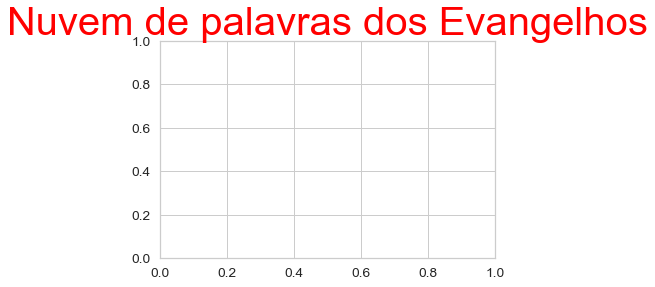

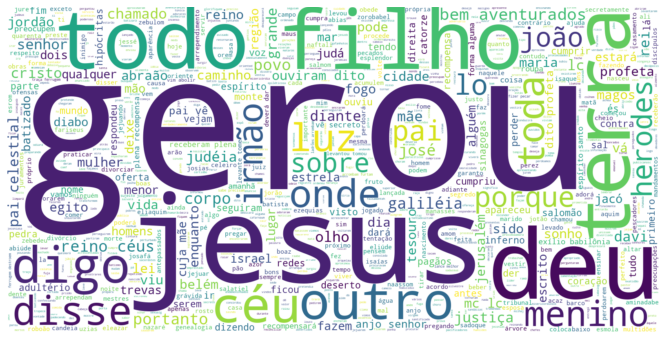

In [205]:
"""
#Exploratory Analysis
# Import the wordcloud library
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

#Concatenar as palavras
data_words = " ".join(list(data_clean['doc'].values))

#stopwords=nltk.corpus.stopwords.words('portuguese')


stopwords= set(STOPWORDS) ##Definindo uma lista de STOPWORDS  Tutorial 6
stopwords.update(["de","a", "o", "que","e","do", "da", "em", "um", "para", "é", "com", "não", "uma", "os", "no", "se", "na", "por", 
                  "mais", "as", "dos", "como", "mas", "foi", "ao", "ele", "das", "tem", "à","às","seu", "sua","ou", 
                  "ser", "quando", "muito", "há", "nos", "já", "está", "eu", "também", "só", "pelo", "pela",  
                  "até", "isso" ,"ela", "entre", "era", "depois", "sem", "mesmo", "aos", "onde"
                  "ter", "seus", "quem", "nas", "me", "esse", "eles", "estão", "você","tinha", "foram", "essa", 
                  "num", "nem", "suas", "meu", "às", "minha","têm", "numa", "pelos", "elas", 
                  "havia", "seja", "qual", "será", "nós", "tenho", "lhe", "deles", "essas", "esses", "pelas", "este", "fosse", "dele", 
                  "tu", "te","vocês","vos", "lhes", "meus", "minhas", "teu", "tua", "teus", "tuas", "nosso", "nossa", "nossos","nossas",
                  "dela", "delas", "esta", "estes", "estas", "aquele", "aquela", "aqueles", "aquelas", "isto", "aquilo", "estou", "está", 
                  "estamos", "estão", "estive", "esteve", "estivemos", "estiveram", "estava", "estávamos", "estavam", "estivera", "estivéramos", "esteja",
                  "estejamos", "estejam","estivesse", "estivéssemos","estivessem", "estiver", "estivermos", 
                  "estiverem", "hein", "há", "havemos", "hão", "houve", "houvemos", "houveram", "houvera", 
                  "houvéramos", "haja", "hajamos", "hajam","houvesse", "houvéssemos", "houvessem", "houver", "houvermos", "houverem", "houverei", 
                  "houverá", "houveremos", "houverão", "houveria","houveríamos", "houveriam" ,"sou" ,"somos" ,"são" ,"era", "éramos" ,"eram", "fui", "foi", "fomos", "foram", "fora", "fôramos", "seja", 
                  "sejamos", "sejam", "fosse", "fôssemos", "fossem", "for" ,"formos", "forem", "serei", 
                  "será", "seremos", "serão","seria","seríamos" ,"seriam" ,"tenho","tem","temos",
                  "têm","tinha" ,"tínhamos" ,"tinham" ,"tive" ,"teve" ,"tivemos","tiveram","tivera","tivéramos",
                  "tenha", "tenhamos","tenham","tivesse","tivéssemos","tivessem","tiver","tivermos","tiverem",
                  "terei","terá","teremos","terão", "teria","teríamos","teriam","então","assim", "pois"])

# Criar uma WordCloud
wordcloud= WordCloud(stopwords= stopwords,background_color="white",  
                     contour_width=3,contour_color="steelblue",
                     max_words=50000,random_state=42, width=1600, height=800)

#Gerar a WordCloud
for index, doc in enumerate(data_clean.columns):
    wordcloud.generate(data_words)

# Visualizar as WorldCloud
# Mostrar a imagem final 
import matplotlib.pyplot as plt

plt.title("Nuvem de palavras dos Evangelhos", fontsize=40, color="red")
fig, ax=plt.subplots(figsize=(16,6))
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_axis_off()
wordcloud.to_image()

wordcloud.to_file("WorldCloud_lda_gospels.png")
 """

In [207]:
"""
#Vamos criar uma função para encontrar os substantivos ---  
from nltk import word_tokenize, pos_tag


def nouns(doc): 
    is_noun = lambda pos: pos[:2] == "NN"
    tokenized = word_tokenize(doc)
    all_nouns = [word for (word,pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)
 """

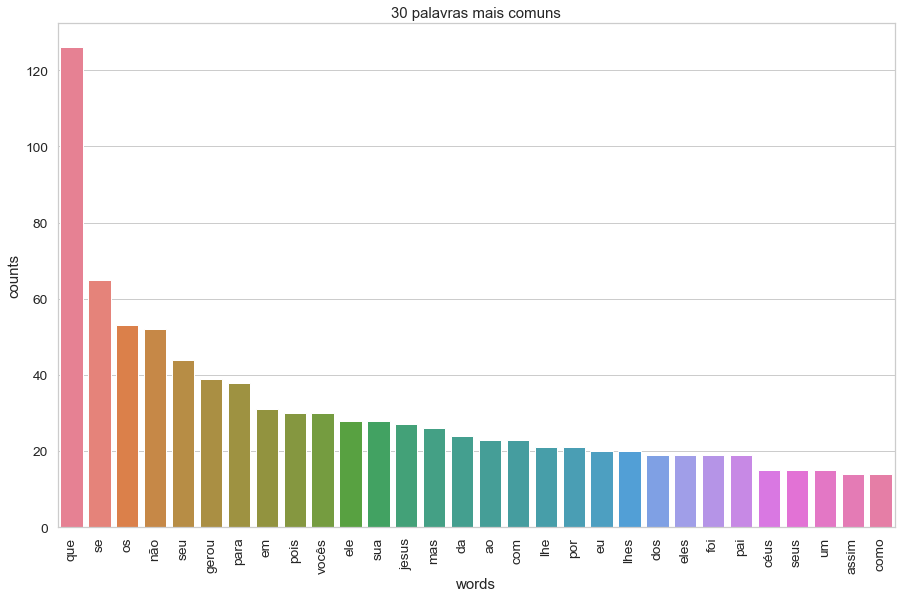

AttributeError: module 'matplotlib.pyplot' has no attribute 'save_to_file'

Wall time: 0 ns


NameError: name 'lda' is not defined